### Model

Initially, we consider a model to find the causal effect of $t$ on $y$ given instruments $z$:

\begin{align*}
y &= \alpha(x) + \beta(x) t + v \\
t &= \kappa(x) + \delta(x) z + u \\
\end{align*}

For simulation purposes, we get $x$ from MNIST images of 0 and 1:
\begin{align*}
u &\sim \mathcal{N}(0, 1) \\
v &\sim \mathcal{N}(0, 1) \\
z &\sim \mathcal{N}(0, 1) \\
\end{align*}

The model is modified to include image labels:

\begin{align*}
y &= \alpha(\text{label}) + \beta(\text{label}) t + v \\
t &= \kappa(\text{label}) + \delta(\text{label}) z + u \\
\end{align*}

Option 1: Generate images $x$ and obtain $\alpha, \beta, \kappa, \delta$ via a CNN.

Option 2:
Where the functions $\alpha, \beta, \kappa, \delta$ are defined based on the label:
\begin{align*}
\alpha(\text{label}) &= \begin{cases}
-1 + 0.2 & \text{if label is 0} \\
-1 - 0.3 & \text{if label is 1}
\end{cases} \\
\beta(\text{label}) &= \begin{cases}
1 - 1 & \text{if label is 0} \\
1 - 0.25 & \text{if label is 1}
\end{cases} \\
\kappa(\text{label}) &= \begin{cases}
-1 + 0.5 & \text{if label is 0} \\
-1 + 0.2 & \text{if label is 1}
\end{cases} \\
\delta(\text{label}) &= \begin{cases}
1 - 0.3 & \text{if label is 0} \\
1 + 0.4 & \text{if label is 1}
\end{cases} \
\end{align*}

### Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Image Network

In [ ]:
class CNN(nn.Module):
    def __init__(self, img_size=8, num_filters=1, d_output=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(num_filters * (img_size - 2) * (img_size - 2), d_output)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### Generate data from image

In [ ]:
# Images
n_samples = 10000
img_size = 8
n_channels = 1
x = torch.randn(n_samples, n_channels, img_size, img_size, device=device)

# Params
num_filters = 1
model_ab = CNN(img_size, num_filters, d_output=2).to(device)
model_cd = CNN(img_size, num_filters, d_output=2).to(device)
ab = model_ab(x)
cd = model_cd(x)
a = ab[:, 0]
b = ab[:, 1]
c = cd[:, 0]
d = cd[:, 1]

# Data
u = 0.1*torch.normal(0, 1, size=(n_samples, ), device=device)
v = 0.1*torch.normal(0, 1, size=(n_samples, ), device=device)
z = torch.normal(0, 1, size=(n_samples, ), device=device)
t = c + d * z + u
y = (a + b * c) + (b * d) * z + v + b * u

print(y.shape, t.shape, z.shape, x.shape)

torch.Size([10000]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000, 1, 8, 8])


### Generate data from label

In [ ]:
n_samples = 10000  # Smaller number of samples for minimal execution
img_size = 28    # Image size (MNIST images are 28x28)
n_channels = 1   # Number of channels (1 for black and white)
x = torch.randn(n_samples, n_channels, img_size, img_size, device=device)
x_label = torch.randint(0, 2, (n_samples,), device=device)

def compute_parameters_fake(x_label):
    a = -1 + 0 * (0.2 if x_label == 0 else -0.3)
    b = 1 + 0 * (0.2 if x_label == 0 else -0.3)
    c = -1 + 0 * (0.2 if x_label == 0 else -0.3)
    d = 1 + 0 * (0.2 if x_label == 0 else -0.3)
    return a, b, c, d

y, t, z = [], [], []
a_array, b_array, c_array, d_array = [], [], [], []

for i in range(n_samples):
    label = x_label[i]
    a, b, c, d = compute_parameters_fake(label)
    u = torch.normal(0, 1, size=(1,)).item()
    v = torch.normal(0, 1, size=(1,)).item()
    z_val = torch.normal(0, 1, size=(1,)).item()
    t_val = c + d * z_val + u
    y_val = (a + b * c) + (b * d) * z_val + v + b * u
    y.append(y_val)
    t.append(t_val)
    z.append(z_val)
    a_array.append(a)
    b_array.append(b)
    c_array.append(c)
    d_array.append(d)

y = torch.tensor(y, device=device)
t = torch.tensor(t, device=device)
z = torch.tensor(z, device=device)
a = torch.tensor(a_array, device=device)
b = torch.tensor(b_array, device=device)
c = torch.tensor(c_array, device=device)
d = torch.tensor(d_array, device=device)
print(y.shape, t.shape, z.shape, x.shape)

torch.Size([10000]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000, 1, 28, 28])


### Forward pass check

In [ ]:
# Check forward pass
model_ab = CNN(img_size, num_filters, d_output=2).to(device)
model_cd = CNN(img_size, num_filters, d_output=2).to(device)
ab = model_ab(x)
cd = model_cd(x)
alpha = ab[:, 0]  # Ensuring correct dimension
beta = ab[:, 1]   # Ensuring correct dimension
kappa = cd[:, 0]  # Ensuring correct dimension
delta = cd[:, 1]
t_hat = (kappa + delta * z).to(device)
y_hat = ((alpha + beta * kappa) + (beta * delta) * z).to(device)
print(alpha.shape, beta.shape, kappa.shape, delta.shape, y_hat.shape, t_hat.shape)
print(t_hat.shape, y_hat.shape)
loss_fn = nn.MSELoss(reduction='mean')
loss = loss_fn(t_hat, t) + loss_fn(y_hat, y)
print(loss)

torch.Size([10000]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000])
torch.Size([10000]) torch.Size([10000])
tensor(0.8751, device='cuda:0', grad_fn=<AddBackward0>)


### Train and Evaluate


 	 R2 a -2.282083733799704 R2 b -0.32183374790645836
Loss: 0.7320400476455688, (Test) R2 T: -0.8852021351418171, (Test) R2 Y: -1.2542126133276694

 	 R2 a -0.16360338842596311 R2 b -0.03143594813239825
Loss: 0.22629663348197937, (Test) R2 T: 0.5346136962911683, (Test) R2 Y: 0.008688539882274582

 	 R2 a 0.39529208834316276 R2 b 0.39040691225488844
Loss: 0.14066551625728607, (Test) R2 T: 0.6681958926750708, (Test) R2 Y: 0.433142654622933

 	 R2 a 0.6679000497466943 R2 b 0.561014635176463
Loss: 0.10131149739027023, (Test) R2 T: 0.7419759045700076, (Test) R2 Y: 0.624506221071522

 	 R2 a 0.7298775050861621 R2 b 0.6437291848704252
Loss: 0.07942752540111542, (Test) R2 T: 0.8097598128144864, (Test) R2 Y: 0.6807410661123543

 	 R2 a 0.7538004840433423 R2 b 0.6820499033307174
Loss: 0.05927241966128349, (Test) R2 T: 0.8912503809507928, (Test) R2 Y: 0.7088090517785223

 	 R2 a 0.7698940658055886 R2 b 0.6968522765709317
Loss: 0.04369232803583145, (Test) R2 T: 0.9454616356965301, (Test) R2 Y: 0.7

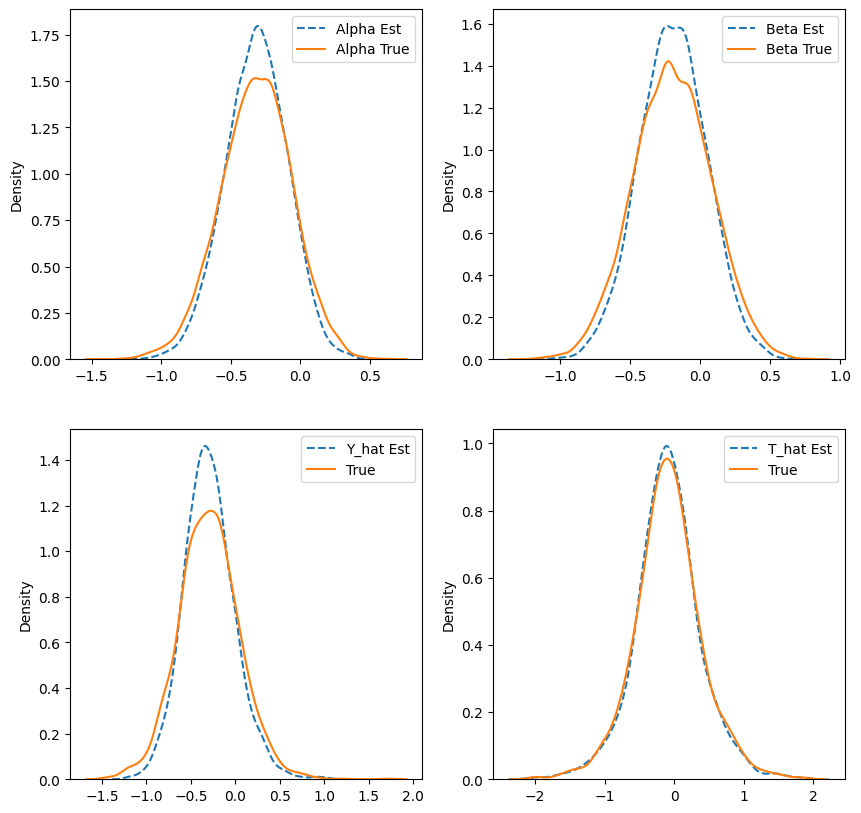

(CNN(
   (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
   (fc1): Linear(in_features=36, out_features=2, bias=True)
 ),
 CNN(
   (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
   (fc1): Linear(in_features=36, out_features=2, bias=True)
 ),
 tensor([-0.7609, -0.3817, -0.5150,  ..., -0.3939, -0.6701, -0.0570],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([ 0.7743,  0.1267,  0.5096,  ...,  0.2048,  0.6107, -0.2274],
        device='cuda:0', grad_fn=<AddBackward0>))

In [ ]:
def network(y, t, z, x, trua=None, trub=None):

    # Split data and Initialize
    x_train, x_test, y_train, y_test, t_train, t_test, z_train, z_test = train_test_split(x, y, t, z, test_size=0.2)
    model_ab = CNN(img_size, num_filters, d_output=2).to(device)
    model_cd = CNN(img_size, num_filters, d_output=2).to(device)
    optimizer = Adam(chain(model_ab.parameters(), model_cd.parameters()), lr=0.0001)
    loss_fn = nn.MSELoss(reduction='mean')

    # Train
    epochs = 10000
    for epoch in range(epochs):
        ab = model_ab(x_train)
        cd = model_cd(x_train)
        alpha = ab[:, 0]
        beta = ab[:, 1]
        kappa = cd[:, 0]
        delta = cd[:, 1]
        t_hat = (kappa + delta * z_train).to(device)
        y_hat = ((alpha + beta * kappa) + (beta * delta) * z_train).to(device)
        loss = loss_fn(t_hat, t_train) + loss_fn(y_hat, y_train)

        # Regularize
        l2_lambda = 0.0001
        l2_reg = torch.tensor(0.).to(device)
        for param in model_ab.parameters():
            l2_reg += torch.norm(param)
        for param in model_cd.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % (epochs/10) == 0:
            with torch.no_grad():
                ab = model_ab(x_test)
                cd = model_cd(x_test)
                alpha = ab[:,0].reshape(-1,)
                beta = ab[:,1].reshape(-1,)
                kappa = cd[:,0].reshape(-1,)
                delta = cd[:,1].reshape(-1,)
                t_hat_test = (kappa + delta * z_test).to(device)
                y_hat_test = ((alpha + beta * kappa) + (beta * delta) * z_test).to(device)
                r2_t = r2_score(t_test.cpu(), t_hat_test.cpu())
                r2_y = r2_score(y_test.cpu(), y_hat_test.cpu())
                if trua is not None:
                    ab = model_ab(x)
                    alpha = ab[:,0].reshape(-1,)
                    beta = ab[:,1].reshape(-1,)
                    r2_a = r2_score(a.cpu(), alpha.cpu())
                    r2_b = r2_score(b.cpu(), beta.cpu())
                    print('\n \t R2 a', r2_a, 'R2 b', r2_b)
            print(f"Loss: {loss.item()}, (Test) R2 T: {r2_t}, (Test) R2 Y: {r2_y}")


    # Plot
    print('\nPlotting Params and Preds\n')
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    sns.kdeplot(alpha.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha Est', linestyle="--")
    if trua is not None:
        sns.kdeplot(a.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha True')
    axs[0, 0].legend()
    sns.kdeplot(beta.cpu().detach().numpy(), ax=axs[0, 1], label='Beta Est', linestyle="--")
    if trub is not None:
        sns.kdeplot(b.cpu().detach().numpy(), ax=axs[0, 1], label='Beta True')
    axs[0, 1].legend()
    sns.kdeplot(y_hat_test.cpu().detach().numpy(), ax=axs[1, 0], label='Y_hat Est', linestyle="--")
    sns.kdeplot(y_test.cpu().detach().numpy(), ax=axs[1, 0], label='True')
    axs[1, 0].legend()
    sns.kdeplot(t_hat_test.cpu().detach().numpy(), ax=axs[1, 1], label='T_hat Est', linestyle="--")
    sns.kdeplot(t_test.cpu().detach().numpy(), ax=axs[1, 1], label='True')
    axs[1, 1].legend()
    plt.show()
    return model_ab, model_cd, y_hat, t_hat

network(y, t, z, x, a, b)

In [ ]:
import pandas as pd
import numpy as np
file_path = 'used_car_sales.csv'
car_data = pd.read_csv(file_path)
car_data['ModelID'] = car_data['Make'] + "_" + car_data['Model']
car_data['MarketID'] = car_data['zipcode'].str[:3]
car_data['ModelAge'] = 2020 - car_data['Year']
car_data['Decade'] = (car_data['Year'] // 10) * 10  # Extracting decade
car_data['CombinedID_Decade'] = car_data['ModelID'] + "_" + car_data['Decade'].astype(str) + "s_" + car_data['BodyType']
car_data = car_data[car_data['CombinedID_Decade'].map(car_data['CombinedID_Decade'].value_counts()) >= 50]
columns_to_keep = ['yearsold', 'pricesold', 'MarketID', 'CombinedID_Decade', 'Mileage', 'ModelAge', 'NumCylinders']
car_data_reduced = car_data[columns_to_keep]
car_data_reduced = car_data_reduced.rename(columns={
    'yearsold': 'year',
    'pricesold': 'price',
    'MarketID': 'market',
    'CombinedID_Decade': 'model',
    'Mileage': 'mileage',
    'ModelAge': 'age',
    'NumCylinders': 'numcyl'
})
df = car_data_reduced
df.head()
print(df.shape)
print(df.model.nunique())

(48474, 7)
435


In [ ]:
ivs.head()

,sum.other.avg_mileage,sum.other.avg_age,sum.other.avg_numcyl,sum.rival.avg_mileage,sum.rival.avg_age,sum.rival.avg_numcyl
0,517424.0,98.0,36.0,128700.0,12.0,0.0
1,1484564.0,407.0,96.0,216000.0,15.0,6.0
2,9160502.666667,2311.833333,526.0,224687.0,18.0,6.0
3,22492014.866667,2391.083333,670.666667,115919.0,13.0,6.0
4,11051098.666667,1585.5,502.0,107000.0,12.0,0.0


In [ ]:
# Calculate sales share and average characteristics for each model in each market and year
grouped = df.groupby(['market', 'year', 'model']).agg(
    total_sales=('model', 'count'),
    avg_mileage=('mileage', 'mean'),
    avg_age=('age', 'mean'),
    avg_numcyl=('numcyl', 'mean')
).reset_index()

# Calculate the total sales in each market and year
market_year_total = grouped.groupby(['market', 'year'])['total_sales'].transform('sum')

# Calculate sales share for each model
grouped['sales_share'] = grouped['total_sales'] / market_year_total
grouped['log_sales_share'] = np.log(grouped['sales_share'])

# Display the grouped data
grouped.head()
grouped.shape

(33636, 9)

In [ ]:
def construct_iv(df, x_cols):
    n = df.shape[0]
    p = len(x_cols)

    model_id = df['model'].values
    market_id = df['market'].values
    year_id = df['year'].values
    X = df[x_cols]

    sum_other = pd.DataFrame(columns=['sum.other.' + var for var in x_cols], index=df.index)
    sum_rival = pd.DataFrame(columns=['sum.rival.' + var for var in x_cols], index=df.index)

    for i in range(n):
        print(i)
        other_ind = (market_id == market_id[i]) & (year_id == year_id[i]) & (model_id != model_id[i])
        rival_ind = (market_id == market_id[i]) & (year_id == year_id[i]) & (model_id == model_id[i])
        for j in range(p):
            sum_other.iloc[i, j] = X.iloc[:, j][other_ind].sum()
            sum_rival.iloc[i, j] = X.iloc[:, j][rival_ind].sum()

    return pd.concat((sum_other, sum_rival), axis=1)

# Example usage
x_cols = ['avg_mileage', 'avg_age', 'avg_numcyl']  # Example instrumental variables
ivs = construct_iv(model_grouped, x_cols)


In [ ]:
import torch

# Merge the IVs back into the main DataFrame
model_grouped = model_grouped.merge(ivs, left_index=True, right_index=True)

# Calculate log shares
model_grouped['log_shares'] = np.log(model_grouped['sales_share'])

# Creating tensors
t = torch.tensor(model_grouped['avg_price'].values, dtype=torch.float32)  # Prices
y = torch.tensor(model_grouped['log_shares'].values, dtype=torch.float32)  # Log shares

# Assuming images_tensor is already created and maps each model to its corresponding image
model_to_idx = {model: idx for idx, model in enumerate(df['model'].unique())}
x = torch.stack([images_tensor[model_to_idx[model]] for model in model_grouped['model']])  # Images

# For the instruments tensor 'z'
instrument_cols = ['sum.other.' + var for var in x_cols] + ['sum.rival.' + var for var in x_cols]
z = torch.tensor(model_grouped[instrument_cols].values, dtype=torch.float32)  # Instruments

# Display the shapes of the tensors
print(f"Shape of t: {t.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of x: {x.shape}")
print(f"Shape of z: {z.shape}")

IndexError: index 379 is out of bounds for dimension 0 with size 296

In [ ]:
# Assuming you have a list or set of models for which images are available
images_dir = '/content/images'
available_models = {model for model in df['model'].unique() if os.path.exists(os.path.join(images_dir, f"{model.replace(' ', '_')}.jpg"))}

# Filter model_grouped to include only models for which images are available
model_grouped_filtered = model_grouped[model_grouped['model'].isin(available_models)]

# Update model_to_idx to include only available models
model_to_idx = {model: idx for idx, model in enumerate(available_models)}

# Create the image tensor 'x' for available models
x = torch.stack([images_tensor[model_to_idx[model]] for model in model_grouped_filtered['model']])

# Create the other tensors for the filtered DataFrame
t = torch.tensor(model_grouped_filtered['avg_price'].values, dtype=torch.float32)  # Prices
y = torch.tensor(model_grouped_filtered['log_shares'].values, dtype=torch.float32)  # Log shares
z = torch.tensor(model_grouped_filtered[instrument_cols].values, dtype=torch.float32)  # Instruments

# Display the shapes of the tensors
print(f"Shape of t: {t.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of x: {x.shape}")
print(f"Shape of z: {z.shape}")


RuntimeError: stack expects a non-empty TensorList

### Download Model Image

In [ ]:
from bing_image_downloader import downloader
import os
from PIL import Image
import sys
import io

# Define the directory for processed images
images_dir = 'images'

# Process and save the image
def process_and_save_image(image_path, model):
    try:
        with Image.open(image_path) as img:
            img_bw = img.convert('L')  # Convert to black and white
            img_resized = img_bw.resize((120, 120))
            save_path = os.path.join(images_dir, f"{model.replace(' ', '_')}.jpg")
            img_resized.save(save_path)
    except Exception as e:
        print(f"Error processing image for model {model}: {e}")

# Function to download and process the first image
def download_and_process_image(query_string, model):
    # Suppressing the output of the downloader
    original_stdout = sys.stdout
    sys.stdout = io.StringIO()
    downloader.download(query_string, limit=1, output_dir=images_dir, adult_filter_off=True, force_replace=False, timeout=60, verbose=True)
    sys.stdout = original_stdout

    # Try to find and process the downloaded image
    try:
        image_folder = os.path.join(images_dir, query_string.replace(" ", "_"))
        image_file = os.listdir(image_folder)[0]  # Assumes the first file is the desired image
        image_path = os.path.join(image_folder, image_file)
        process_and_save_image(image_path, model)
    except FileNotFoundError:
        print(f"No image found for model {model}")

# Create folder to save images
os.makedirs(images_dir, exist_ok=True)

# Loop through each model in the dataframe
cnt = 1
for model in df['model'].unique():
    query_string = f"{model.replace('_', ' ')} car"
    download_and_process_image(query_string, model)
    print(cnt)
    cnt += 1

### Load image as tensor

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Directory containing the images
image_dir = 'images'  # Update this path if your images are stored in a different directory

# Initialize a list to store individual image tensors
image_tensors = []

# Transformation: resize to 120x120 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])

# Loop through each subdirectory in the directory
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)

    # Ensure it's a directory
    if os.path.isdir(subdir_path):
        image_path = os.path.join(subdir_path, 'Image_1.jpg')

        # Process the image if it exists
        if os.path.exists(image_path):
            with Image.open(image_path) as img:
                img_bw = img.convert('L')  # Convert to black and white
                img_tensor = transform(img_bw)
                image_tensors.append(img_tensor)

# Stack all image tensors to create a single tensor
# The final tensor will have shape: (n, 1, 120, 120)
images_tensor = torch.stack(image_tensors)

# Display the shape of the final tensor
print(images_tensor.shape)


torch.Size([296, 1, 120, 120])
